# Bahrain 2024

In [5]:
# pip install fastf1 (without showing the process)
import subprocess

subprocess.run(['pip', 'install', 'fastf1'],
               stdout=subprocess.DEVNULL,
               stderr=subprocess.DEVNULL)


CompletedProcess(args=['pip', 'install', 'fastf1'], returncode=0)

# FastF1

In [6]:
# FastF1 Library: Provides telemetry, lap times, tire wear, and pit stop data.
import fastf1
import pandas as pd
import logging
import warnings

# Disable logging from FastF1
logging.getLogger("fastf1").setLevel(logging.CRITICAL)

# Suppress all Python warnings
warnings.filterwarnings("ignore")

# Optional: Enable caching to speed up repeated runs
# fastf1.Cache.enable_cache('cache')

# Load Bahrain GP Race (2024)
session = fastf1.get_session(2024, 'Bahrain', 'R')
session.load()

# Extract laps data as a DataFrame
bahrain2024 = session.laps


In [7]:
bahrain2024.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:01:37.510000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.266000,...,False,Red Bull Racing,0 days 00:59:59.911000,2024-03-02 15:03:42.342,12,1.0,False,,False,False
1,0 days 01:03:13.806000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaT,NaT,0 days 00:00:30.916000,0 days 00:00:41.661000,...,False,Red Bull Racing,0 days 01:01:37.510000,2024-03-02 15:05:19.941,1,1.0,False,,False,True
2,0 days 01:04:50.559000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaT,NaT,0 days 00:00:30.999000,0 days 00:00:41.966000,...,False,Red Bull Racing,0 days 01:03:13.806000,2024-03-02 15:06:56.237,1,1.0,False,,False,True
3,0 days 01:06:27.206000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaT,NaT,0 days 00:00:30.931000,0 days 00:00:41.892000,...,False,Red Bull Racing,0 days 01:04:50.559000,2024-03-02 15:08:32.990,1,1.0,False,,False,True
4,0 days 01:08:04.379000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaT,NaT,0 days 00:00:31.255000,0 days 00:00:42.056000,...,False,Red Bull Racing,0 days 01:06:27.206000,2024-03-02 15:10:09.637,1,1.0,False,,False,True


In [8]:
bahrain2024.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'],
      dtype='object')

| # | Strategy Feature                 | Mapped Column(s) in `bahrain2024`                        | Notes                                                          |
|---|----------------------------------|-----------------------------------------------------------|----------------------------------------------------------------|
| 1 | **Pace of tyre/car**             | `LapTime`, `Position`                                     | Use lap time and position to estimate raw pace.                |
| 2 | **Warmup on the tyre**           | `TyreLife`, `FreshTyre`, `Compound`                       | Analyze lap time trends on new tyres.                          |
| 3 | **Tyre degradation**             | `LapTime`, `TyreLife`, `Compound`, `Stint`                | Use pace vs TyreLife to infer degradation.                     |
| 4 | **Performance life (tyre)**      | `TyreLife`, `Compound`, `LapNumber`                       | Model how long each compound remains quick.                    |
| 5 | **Wear life**                    | `TyreLife`, `Compound`, `Stint`                           | Related to performance life but focused on stint usage span.   |
| 6 | **Track temperature / tyre temperature** | ❌ *Not available directly*                      | Consider estimating or flag as missing.                        |
| 7 | **Time to complete pitstop**     | `PitOutTime`, `PitInTime`                                 | Calculate pit stop duration.                                   |


In [9]:
import numpy as np

# Copy original DataFrame
df = bahrain2024.copy()

# Convert lap time to seconds
df['LapTime_sec'] = df['LapTime'].dt.total_seconds()

# --------------------------------------
# 🏁 Feature 1: Pace of tyre/car
# --------------------------------------
# Already covered by 'LapTime_sec' and 'Position'

# --------------------------------------
# 🧊 Feature 2: Warmup on the tyre
# --------------------------------------
df['IsFreshTyre'] = df['FreshTyre'].fillna(False)

# --------------------------------------
# 🔻 Feature 3: Tyre degradation
# --------------------------------------
df['DegradationPerLap'] = df.groupby(['Driver', 'Stint'])['LapTime_sec'].diff().fillna(0)

# --------------------------------------
# ⏱️ Feature 4: Performance life (tyre)
# --------------------------------------
performance_life = df.groupby(['Compound', 'TyreLife'])['LapTime_sec'].mean().reset_index()
# (Optional: Use this for plotting or regression)

# --------------------------------------
# 🔧 Feature 5: Wear life
# --------------------------------------
stint_life = df.groupby(['Driver', 'Stint'])['LapNumber'].count().reset_index()
stint_life.columns = ['Driver', 'Stint', 'StintLength']
df = df.merge(stint_life, on=['Driver', 'Stint'], how='left')

# --------------------------------------
# 🛑 Feature 6: Track temp / tyre temp
# --------------------------------------
# ❌ Not available

# --------------------------------------
# 🕓 Feature 7: Time to complete pitstop (corrected)
# --------------------------------------
# Step 1: Sort by Driver and LapNumber
df = df.sort_values(by=['Driver', 'LapNumber']).reset_index(drop=True)

# Step 2: Shift PitOutTime backward to match with previous lap's PitInTime
df['NextPitOutTime'] = df.groupby('Driver')['PitOutTime'].shift(-1)

# Step 3: Identify pitstop rows (where PitInTime is not null)
df['PitDuration'] = (df['NextPitOutTime'] - df['PitInTime']).dt.total_seconds()

# Step 4: Clean up invalid durations
df.loc[df['PitDuration'] <= 0, 'PitDuration'] = np.nan

# ✅ Final enriched DataFrame preview
df.head()


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTime_sec,IsFreshTyre,DegradationPerLap,StintLength,NextPitOutTime,PitDuration
0,0 days 01:01:44.114000,ALB,23,0 days 00:01:43.888000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:44.007000,...,False,,False,False,103.888,True,0.000,15,NaT,NaN
1,0 days 01:03:22.940000,ALB,23,0 days 00:01:38.826000,2.0,1.0,NaT,NaT,0 days 00:00:31.419000,0 days 00:00:43.106000,...,False,,False,True,98.826,True,-5.062,15,NaT,NaN
2,0 days 01:05:01.447000,ALB,23,0 days 00:01:38.507000,3.0,1.0,NaT,NaT,0 days 00:00:31.002000,0 days 00:00:43.081000,...,False,,False,True,98.507,True,-0.319,15,NaT,NaN
3,0 days 01:06:39.869000,ALB,23,0 days 00:01:38.422000,4.0,1.0,NaT,NaT,0 days 00:00:31.023000,0 days 00:00:43.007000,...,False,,False,True,98.422,True,-0.085,15,NaT,NaN
4,0 days 01:08:18.378000,ALB,23,0 days 00:01:38.509000,5.0,1.0,NaT,NaT,0 days 00:00:31.049000,0 days 00:00:43.027000,...,False,,False,True,98.509,True,0.087,15,NaT,NaN


| # | Plot Title                     | What It Shows                        | Insight for Strategy                          |
|----|-------------------------------|--------------------------------------|-----------------------------------------------|
| 1  | 📉 Lap Time vs Tyre Life      | Pace degradation by compound         | How long a tyre remains competitive           |
| 2  | 📊 Average Pit Duration       | Who had long/short pit stops         | Pit crew performance                          |
| 3  | 🔁 Tyre Usage Distribution    | How often each compound was used     | Strategy trends (e.g., 2-stop on softs)       |
| 4  | 📈 Lap Time Trend in Stint    | Warm-up and degradation per stint    | Stint dynamics for a driver                   |
| 5  | 🔍 Stint Length by Compound   | How long each compound is driven     | Compound durability for stint planning        |


In [10]:
df.isnull().sum()

Time                     0
Driver                   0
DriverNumber             0
LapTime                  2
LapNumber                0
Stint                    0
PitOutTime            1086
PitInTime             1086
Sector1Time             21
Sector2Time              0
Sector3Time              0
Sector1SessionTime      22
Sector2SessionTime       0
Sector3SessionTime       0
SpeedI1                300
SpeedI2                  0
SpeedFL                 43
SpeedST                170
IsPersonalBest           0
Compound                 0
TyreLife                 0
FreshTyre                0
Team                     0
LapStartTime             0
LapStartDate             0
TrackStatus              0
Position                 0
Deleted                  0
DeletedReason            0
FastF1Generated          0
IsAccurate               0
LapTime_sec              2
IsFreshTyre              0
DegradationPerLap        0
StintLength              0
NextPitOutTime        1086
PitDuration           1086
d

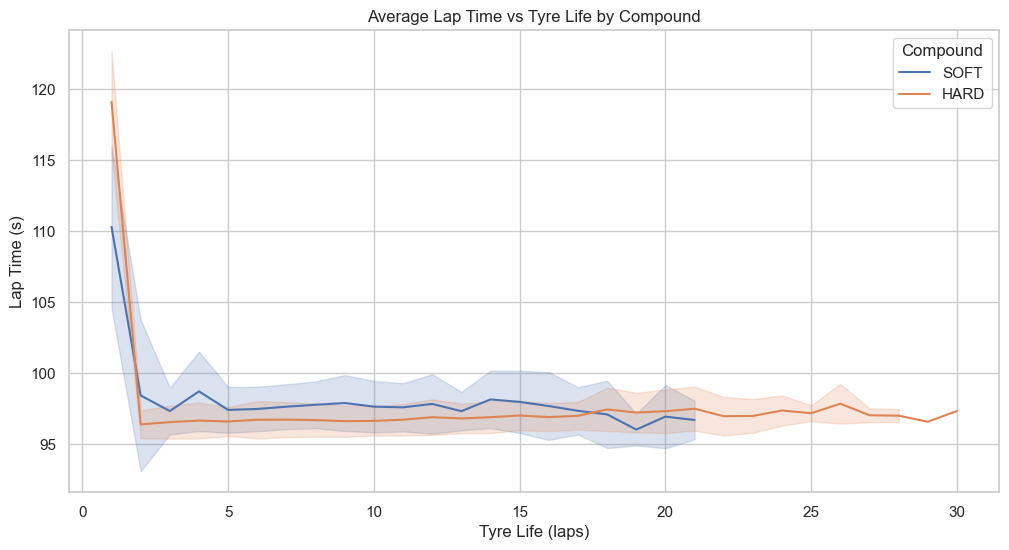

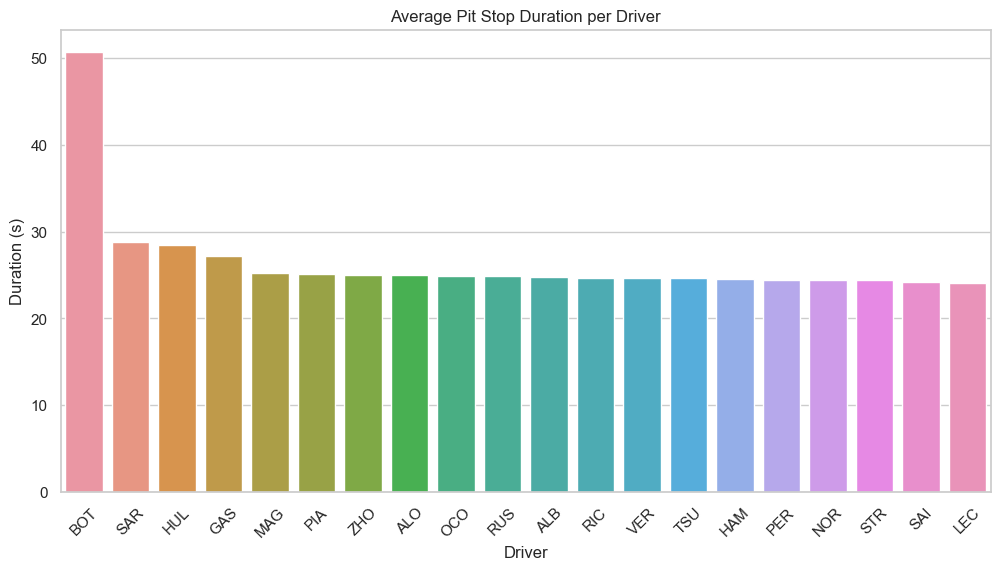

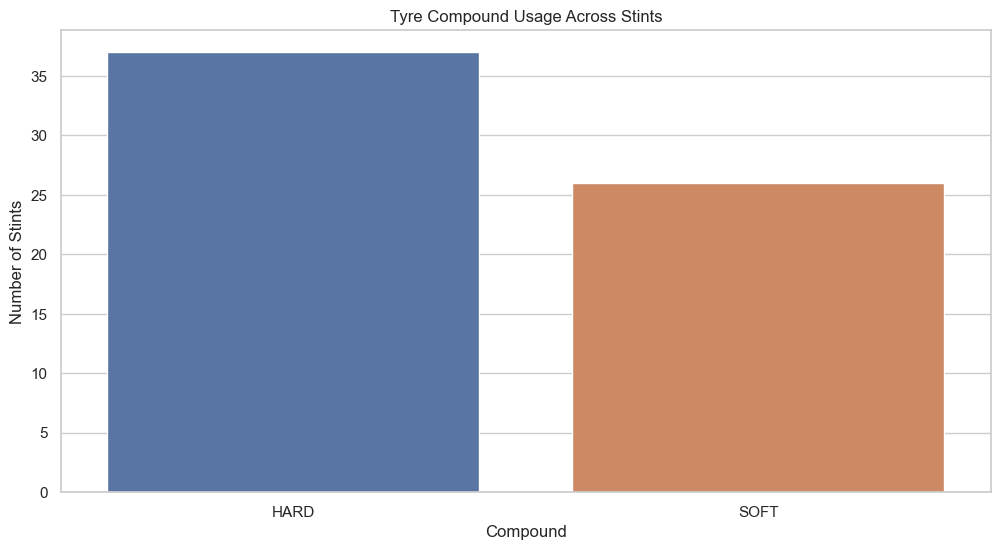

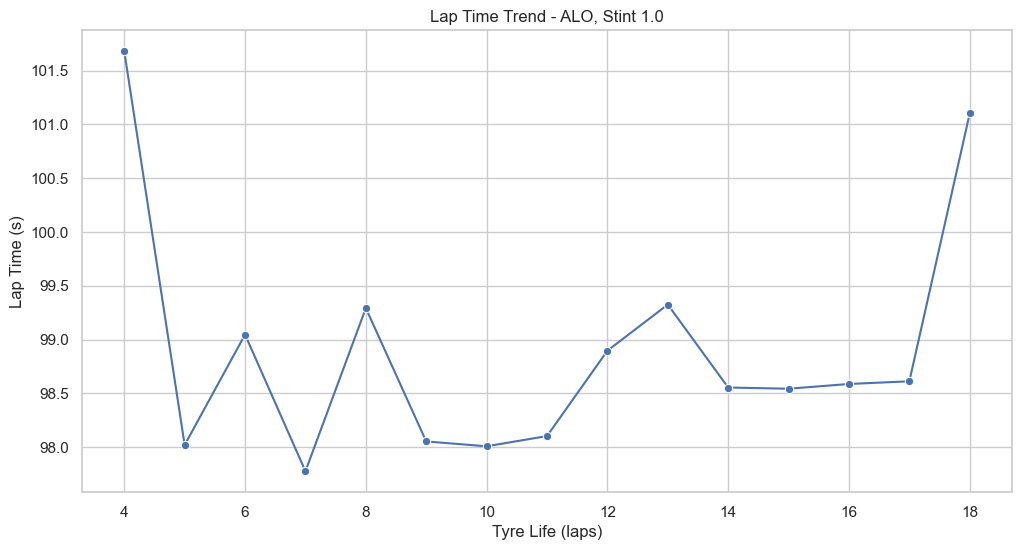

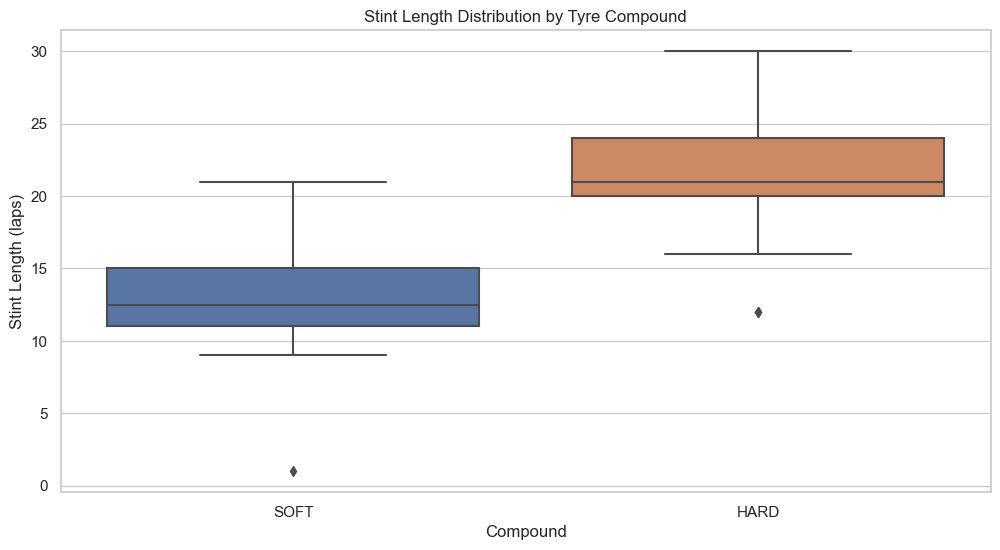

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 1️⃣ Lap Time vs Tyre Life (Grouped by Compound)
plt.figure()
sns.lineplot(data=df, x='TyreLife', y='LapTime_sec', hue='Compound', estimator='mean', ci='sd')
plt.title("Average Lap Time vs Tyre Life by Compound")
plt.ylabel("Lap Time (s)")
plt.xlabel("Tyre Life (laps)")
plt.legend(title="Compound")
plt.show()

# 2️⃣ Average Pit Duration by Driver (Using corrected PitDuration)
df_pitstops = df[df['PitDuration'].notna()]
avg_pit = df_pitstops.groupby('Driver')['PitDuration'].mean().reset_index()

plt.figure()
sns.barplot(data=avg_pit, x='Driver', y='PitDuration', order=avg_pit.sort_values('PitDuration', ascending=False)['Driver'])
plt.title("Average Pit Stop Duration per Driver")
plt.ylabel("Duration (s)")
plt.xticks(rotation=45)
plt.show()

# 3️⃣ Tyre Usage Distribution
plt.figure()
df_stints = df.drop_duplicates(subset=['Driver', 'Stint'])
sns.countplot(data=df_stints, x='Compound', order=df['Compound'].value_counts().index)
plt.title("Tyre Compound Usage Across Stints")
plt.ylabel("Number of Stints")
plt.xlabel("Compound")
plt.show()

# 4️⃣ Lap Time Trend in a Stint (Example: most common driver + their first stint)
example_driver = df['Driver'].mode().iloc[0]
first_stint = df[df['Driver'] == example_driver]['Stint'].min()
subset = df[(df['Driver'] == example_driver) & (df['Stint'] == first_stint)]

plt.figure()
sns.lineplot(data=subset, x='TyreLife', y='LapTime_sec', marker='o')
plt.title(f"Lap Time Trend - {example_driver}, Stint {first_stint}")
plt.ylabel("Lap Time (s)")
plt.xlabel("Tyre Life (laps)")
plt.show()

# 5️⃣ Stint Length by Compound
plt.figure()
sns.boxplot(data=df_stints, x='Compound', y='StintLength')
plt.title("Stint Length Distribution by Tyre Compound")
plt.ylabel("Stint Length (laps)")
plt.xlabel("Compound")
plt.show()


issues with pitspot duration calculation

In [12]:
import matplotlib.pyplot as plt
def plot_degradation_by_compound(df, Driver):
    # F1 compound color map
    compound_colors = {
        'SOFT': '#FF3333',         # Red
        'MEDIUM': '#FFD700',       # Yellow
        'HARD': '#A9A9A9',         # Grey
        'INTERMEDIATE': '#32CD32', # Green
        'WET': '#1E90FF'           # Blue
    }

    # Filter and clean
    driver_df = df[df['Driver'] == Driver].copy()
    driver_df = driver_df[driver_df['LapTime_sec'].notnull()]

    plt.figure(figsize=(12, 6))

    # Plot each stint-compound combo separately
    for (stint, compound), stint_df in driver_df.groupby(['Stint', 'Compound']):
        plt.plot(
            stint_df['LapNumber'],
            stint_df['LapTime_sec'],
            label=f'{compound} - Stint {stint}',
            color=compound_colors.get(compound.upper(), 'black'),
            marker='o',
            linewidth=2
        )
    
    plt.title(f'Tyre Degradation by Compound – {Driver}')
    plt.xlabel('Lap Number')
    plt.ylabel('Lap Time (s)')
    plt.legend(title='Compound + Stint')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


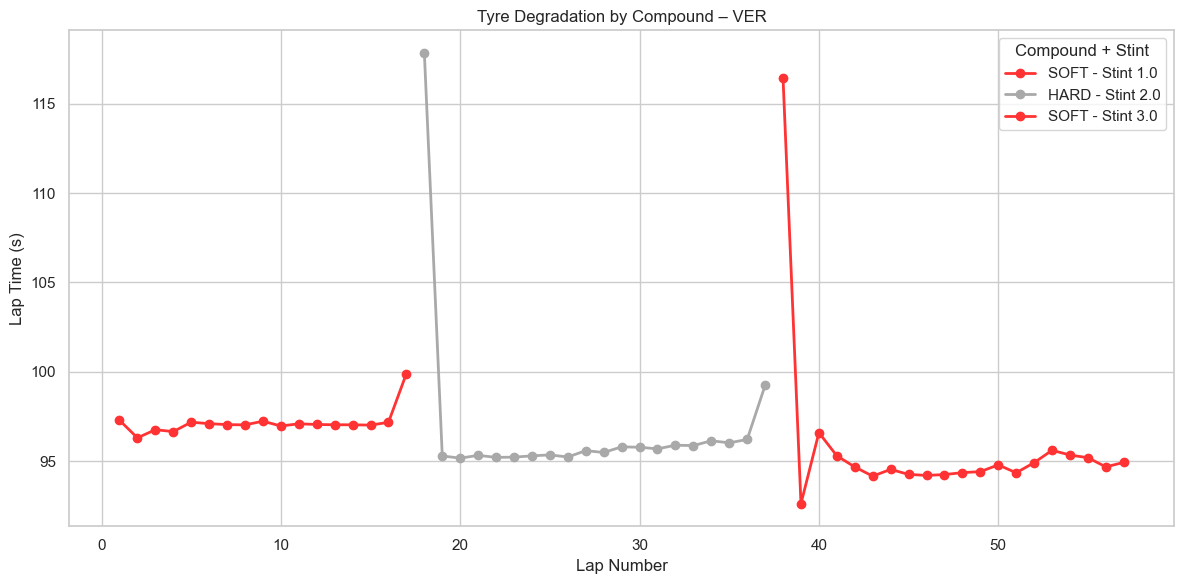

In [13]:
plot_degradation_by_compound(df, Driver='VER')  # or any other driver like 'HAM', 'LEC', etc.


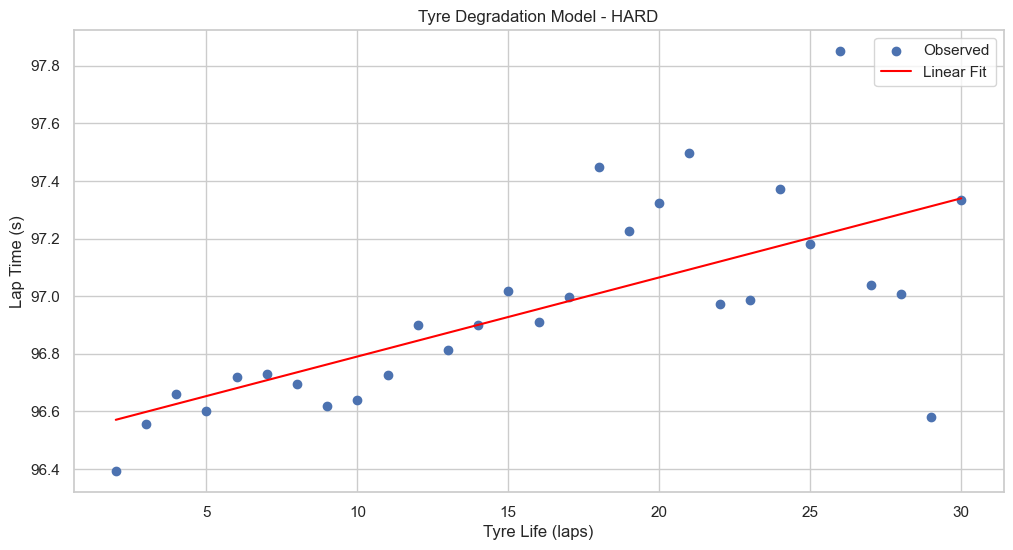

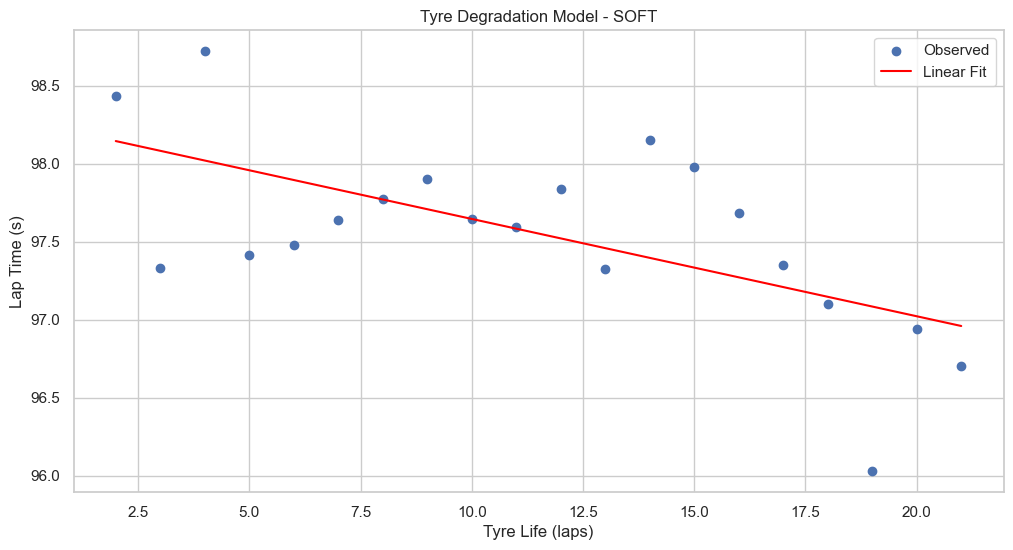

In [23]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Group by compound and tyre life, and compute mean lap time
compound_degradation = df.groupby(['Compound', 'TyreLife'])['LapTime_sec'].mean().reset_index()

# Remove first lap (TyreLife == 1) as it might be an outlier
compound_degradation = compound_degradation[compound_degradation['TyreLife'] > 1]

# Fit one linear model per compound
degradation_models = {}

for compound in compound_degradation['Compound'].unique():
    data = compound_degradation[compound_degradation['Compound'] == compound]
    X = data['TyreLife'].values.reshape(-1, 1)
    y = data['LapTime_sec'].values

    model = LinearRegression()
    model.fit(X, y)
    degradation_models[compound] = model

    # Plotting
    plt.figure()
    plt.scatter(X, y, label='Observed')
    plt.plot(X, model.predict(X), color='red', label='Linear Fit')
    plt.title(f"Tyre Degradation Model - {compound}")
    plt.xlabel("Tyre Life (laps)")
    plt.ylabel("Lap Time (s)")
    plt.legend()
    plt.grid(True)
    plt.show()



In [24]:
# Race length
race_laps = 57
pit_time_loss = 23  # Seconds added for a pit stop

# Use degradation models from earlier
soft_model = degradation_models['SOFT']
hard_model = degradation_models['HARD']

def simulate_stint(model, laps):
    tyre_life = np.arange(1, laps + 1).reshape(-1, 1)
    lap_times = model.predict(tyre_life)
    return lap_times.sum()

# Define strategies
strategies = {
    'Soft → Hard': [ ('SOFT', 18), ('HARD', 39) ],
    'Hard → Soft': [ ('HARD', 35), ('SOFT', 22) ],
    'Soft → Soft → Hard': [ ('SOFT', 15), ('SOFT', 15), ('HARD', 27) ],
    'Hard → Soft → Soft': [ ('HARD', 20), ('SOFT', 18), ('SOFT', 19) ]
}

# Simulate total race time
strategy_results = {}

for name, stints in strategies.items():
    total_time = 0
    for compound, laps in stints:
        model = soft_model if compound == 'SOFT' else hard_model
        total_time += simulate_stint(model, laps)
    total_time += (len(stints) - 1) * pit_time_loss  # Add pit time for each stop
    strategy_results[name] = total_time

# Display results
sorted_results = sorted(strategy_results.items(), key=lambda x: x[1])
for strat, time_sec in sorted_results:
    print(f"{strat}: {time_sec:.2f} seconds ({time_sec/60:.2f} mins)")


Hard → Soft: 5564.48 seconds (92.74 mins)
Soft → Hard: 5566.70 seconds (92.78 mins)
Soft → Soft → Hard: 5595.39 seconds (93.26 mins)
Hard → Soft → Soft: 5595.50 seconds (93.26 mins)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Select features and drop NaNs
ml_df = df[[
    'LapTime_sec', 'TyreLife', 'Compound', 'StintLength',
    'IsFreshTyre', 'DegradationPerLap'
]].dropna()

# Split into features and target
X = ml_df.drop('LapTime_sec', axis=1)
y = ml_df['LapTime_sec']

# One-hot encode compound
categorical = ['Compound']
numeric = ['TyreLife', 'StintLength', 'IsFreshTyre', 'DegradationPerLap']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric),
        ('cat', OneHotEncoder(), categorical)
    ]
)

# Define model pipeline
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model MAE: {mae:.3f} sec")
print(f"Model R² : {r2:.3f}")


Model MAE: 0.824 sec
Model R² : 0.838


In [26]:
import pandas as pd

def simulate_stint_with_model(model, compound, stint_length, start_tyre_life=1):
    laps = []
    for i in range(start_tyre_life, start_tyre_life + stint_length):
        laps.append({
            'TyreLife': i,
            'StintLength': stint_length,
            'IsFreshTyre': i == 1,
            'DegradationPerLap': 0,  # placeholder if you don’t calculate per lap
            'Compound': compound
        })
    stint_df = pd.DataFrame(laps)
    return model.predict(stint_df)


In [27]:
# Define Max's actual strategy
max_strategy = [('SOFT', 17), ('HARD', 20), ('SOFT', 20)]
pit_time_loss = 23  # average pit stop time

# Simulate each stint
total_lap_times = []
for compound, laps in max_strategy:
    predicted_laps = simulate_stint_with_model(model, compound, laps)
    total_lap_times.extend(predicted_laps)

# Add pit stop penalties
total_predicted_time = sum(total_lap_times) + (len(max_strategy) - 1) * pit_time_loss

# Output
print(f"🏁 Predicted Total Race Time for Max's Actual Strategy (S-H-S): {total_predicted_time:.2f} sec ({total_predicted_time/60:.2f} min)")


🏁 Predicted Total Race Time for Max's Actual Strategy (S-H-S): 5599.85 sec (93.33 min)
